In [23]:
# for autoreloading edited the modules and packages instead of restarting the kernel
%reload_ext autoreload
%autoreload 2

## K-Nearest Neighbors (KNN) model

### 1. data preparation

#### 1.1. prepare dataset

In [24]:
from pathlib import Path
import pandas as pd


In [25]:
data_dir = Path("data_preprocess")
data_path = data_dir / "raw_data\\kickstarter_2021\\kickstarter_2021.csv"

df = pd.read_csv(data_path)
df.describe()


,id,goal,deadline,state_changed_at,created_at,launched_at,backers_count,usd_pledged
count,2.014300e+05,2.014300e+05,2.014300e+05,2.014300e+05,2.014300e+05,2.014300e+05,201430.000000,2.014300e+05
mean,1.073322e+09,5.782680e+04,1.491501e+09,1.491183e+09,1.484291e+09,1.488622e+09,147.280857,1.346047e+04
std,6.192613e+08,1.321779e+06,8.252764e+07,8.217482e+07,8.255653e+07,8.251254e+07,934.928257,1.049981e+05
min,1.852000e+04,1.000000e-02,1.243770e+09,1.243770e+09,1.240366e+09,1.240674e+09,0.000000,0.000000e+00
25%,5.368643e+08,1.500000e+03,1.429502e+09,1.429386e+09,1.423229e+09,1.426637e+09,3.000000,8.613875e+01
50%,1.072915e+09,5.000000e+03,1.487859e+09,1.487777e+09,1.480254e+09,1.484942e+09,24.000000,1.350705e+03
75%,1.609493e+09,1.500000e+04,1.562090e+09,1.561998e+09,1.554744e+09,1.559145e+09,87.000000,6.293718e+03
max,2.147476e+09,1.000000e+08,1.644199e+09,1.639015e+09,1.638994e+09,1.639015e+09,105857.000000,1.138545e+07


***

#### step 2. handle missing values

In [26]:
nan_values = sum(df.isna().sum())
nan_values


0

There are no missing data.  
It was handled before; So there is no need to handle missing data.

***

### Part 2. Feature Selection

#### step 3. select features

In [35]:
from data_preprocess.data_utils import get_processed_data
import numpy as np

In [36]:
x, y = get_processed_data(
    data_path, one_hot_encode=False, target_feature="usd_pledged"
)
x = np.array(x, dtype='float')
x.shape, y.shape, type(x)


((201430, 13), (201430, 1), numpy.ndarray)

---

#### step 4. visualize heatmap

In [37]:
import seaborn as sns


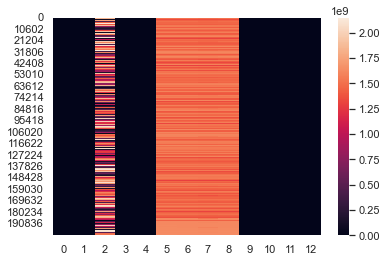

In [38]:
sns.set_theme()
ax = sns.heatmap(x)


comparing values in the above figure is hard because of large differences between feature values.  
the solution is to normalize feature values.

---

#### step 5. standardize input features

In [39]:
from sklearn.preprocessing import StandardScaler


Text(30.5, 0.5, 'examples')

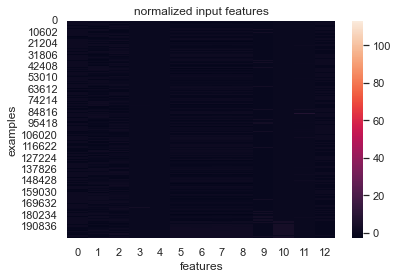

In [40]:
# using z-score method
scaler = StandardScaler()
scaler.fit(x)
x_standard = scaler.transform(x)
sns.set_theme()
ax = sns.heatmap(x_standard)
ax.set_title("normalized input features")
ax.set_xlabel("features")
ax.set_ylabel("examples")


---

#### step 6. split dataset into train and test datasets


In [41]:
from sklearn.model_selection import train_test_split


In [42]:
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=test_size,
    random_state=28,
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((161144, 13), (40286, 13), (161144, 1), (40286, 1))

***

### Part 3. Model Implementation

#### step 7. implement KNN with sklearn

In [44]:
from sklearn.neighbors import KNeighborsRegressor
from knn.train_utils import find_best_hyperparameter, train_knn_with_kfold


In [45]:
# parameters = {
#     "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
#     "leaf_size": [20, 30, 40],
#     "metric": ["minkowski"],
#     "n_jobs": [-1],
#     "n_neighbors": [1, 3, 5, 7, 9, 15, 30, 45, 60, 75, 90, 120, 150, 170],
#     "p": [1, 2, 3],
#     "weights": ["uniform", "distance"],
# }



In [46]:
# regressor = KNeighborsRegressor()
# 
# best_hyperparameter = find_best_hyperparameter(
#     data_path,
#     regressor,
#     parameters=parameters,
#     target_feature='usd_pledged'
# )
# best_hyperparameter


In [47]:
# to set hyperparameters manually
best_hyperparameter = {
    "algorithm": "auto",
    "leaf_size": 30,
    "metric": "minkowski",
    "n_jobs": -1,
    "n_neighbors": 15,
    "p": 2,
    "weights": 'uniform',
}

In [48]:
regressor = KNeighborsRegressor(**best_hyperparameter)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

training_score = regressor.score(x_train, y_train)
test_score = regressor.score(x_test, y_test)

scores = [training_score, test_score]
scores


[0.07650628665075898, -0.07603902523728334]

#### step 8. fine-tune k

In [49]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [51]:
error_rate = []
k_range = 175
range_start = 5
for i in range(range_start, k_range):
    regressor = KNeighborsRegressor(n_neighbors=i)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    error_rate.append(mean_squared_error(y_test, y_pred))

plt.figure()
plt.plot(range(range_start, k_range), error_rate, color="red")
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")
print("Minimum error: ", min(error_rate), "at k =", error_rate.index(min(error_rate)))


KeyboardInterrupt: 

***

### Part 4. Validation

#### step 9. prediction error


In [52]:
from knn.train_utils import train_knn_with_kfold, train_knn
from data_preprocess.data_utils import get_processed_data


In [53]:
error, y_pred = train_knn(
    best_params=best_hyperparameter,
    data_path=data_path,
    target_feature="usd_pledged",
    
)
print(f"mean_error = {error} M$")



NameError: name 'train_knn' is not defined

In [54]:
pd.DataFrame({"y_true": y.squeeze(), "y_pred": y_pred}).to_csv("xgboost_results.csv", index=False)


ValueError: Data must be 1-dimensional